In [17]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
import patchsim as sim
import matplotlib.ticker as plticker
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import hyperopt
from hyperopt import hp, Trials
from tqdm import tqdm

In [18]:
def run_patchsim(x,forecast=False):
    prep_param_file(x)
    if forecast:
        stages = 6
    else:
        stages = 5
        
    for s in range(stages):
        cfg = sim.read_config('../data/patchsim/calib_cps/cfg_stage{}.txt'.format(s))
        sim.run_disease_simulation(cfg,write_epi=True)

    out_df = pd.DataFrame()
    for s in range(stages):
        temp_df = pd.read_csv('../outputs/sample{}.out'.format(s),delimiter=' ',header=None,index_col=0)       
        if s==0:
            out_df = temp_df.copy(deep=True)
        else:
            temp_df.columns = [x+len(out_df.columns) for x in temp_df.columns]
            out_df = out_df.join(temp_df)
    return out_df

In [19]:
def prep_param_file(x):
    stages = 5
    param_df = pd.DataFrame()
    for s in range(stages):
        temp = pd.read_csv('../data/patchsim/calib_cps/param_stage{}.txt'.format(s),delim_whitespace=True)
        temp['stage'] = s
        param_df = param_df.append(temp)

    param_df['beta'] = param_df.apply(lambda row: get_param(row['id'],row['stage'],x),axis=1)
    for s in range(stages):
        param_df[param_df.stage==s][['id','beta','alpha','gamma']].to_csv('../data/patchsim/calib_cps/param_stage{}.txt'.format(s),sep=' ',index=None)
    return

In [20]:
gt = pd.read_csv('../data/Ebola_Updated_Apr21.csv', delimiter=',')
gt['Date'] = gt.date.apply(lambda x: datetime.strptime(str(x),'%Y%m%d'))
gt['Ob_Day'] = gt.Date.apply(lambda x : (x - datetime.strptime('20180805','%Y%m%d')).days)
gt = gt[gt.Date>=datetime.strptime('20180805','%Y%m%d')] ## Starting on August 5th, the first non-NaN value

key_hzs = gt[gt.Date==gt.Date.max()][['health_zone','total_c']].sort_values('total_c',ascending=False).head(7)['health_zone'].values
key_hzs = sorted(list(set(key_hzs) - {'all'}))

T = len(gt[gt.health_zone=='all'])

In [21]:
def drc_error_func(out_df,w):
    y_hat = out_df.sum().cumsum().values
    y = gt[gt.health_zone=='all']['total_c'].values
    diff = np.abs(y_hat-y)
    disc_wt = [w**(len(diff)-1-x) for x in range(len(diff))] 

    return sum(disc_wt*diff)

In [22]:
def hz_error_func(out_df,w):
    calib_key_hzs = key_hzs
    y_hat = out_df.loc[[k.upper() for k in calib_key_hzs]].cumsum(axis=1).values
    y = gt.pivot(index='health_zone',columns='Ob_Day',values='total_c').loc[calib_key_hzs].fillna(0).values
    diff = sum(np.abs(y_hat-y))
    disc_wt = [w**(len(diff)-1-x) for x in range(len(diff))]
    
    return sum(disc_wt*diff)

In [23]:
def agg_error_func(x):
    w = 0.75
    drc_wt = 0
    hz_wt = 1
    
    out_df = run_patchsim(x)
    
    drc_err = drc_error_func(out_df,w)
    hz_err = hz_error_func(out_df,w)
    
    pbar.update()
    return drc_wt*drc_err + hz_wt*hz_err

In [24]:
def get_param(hz,stage,x):
    ## x = [0.250, 0.210, 0.125, 0.070, 0.215, 0.11, 0.18, 0.215]  - Manual parameters
    if (hz=='MABALAKO') & (stage==0): return x[0]       
    if (hz=='BENI') & (stage<=1): return x[1]    
    if (hz in ['BUTEMBO','KATWA']) & (stage==1): return x[2]
    if (hz=='BENI') & (stage==2): return x[3]
    if (hz=='KATWA') & (stage==2): return x[4]
    if (hz in ['BUTEMBO','KATWA','MANDIMA']) & (stage==3): return x[5]
    if (hz=='BENI') & (stage==4): return x[6]
    if (hz in ['KATWA','MANDIMA','VUHOVI']) & (stage==4): return x[7]
    
    return 

In [25]:
column_labels = ['mab_s0','beni_s01','butkat_s1','beni_s2','kat_s2','bkm_s3','beni_s4','kmv_s4']
x_space = [hp.uniform('0',0.24,0.26),
           hp.uniform('1',0.20,0.22),
           hp.uniform('2',0.11,0.14),
           hp.uniform('3',0.06,0.08),
           hp.uniform('4',0.20,0.22),
           hp.uniform('5',0.1,0.12),
           hp.uniform('6',0.16,0.19),
           hp.uniform('7',0.2,0.22)]

In [26]:
trials = Trials()
max_evals = 1000
pbar = tqdm(total=max_evals, desc="Calibration")
x_opt_dict = hyperopt.fmin(agg_error_func, space=x_space, algo=hyperopt.rand.suggest, max_evals=max_evals, trials=trials)  
x_opt = [x_opt_dict[str(i)] for i in range(len(x_space))]
particles_df = pd.DataFrame(dict(sorted({int(k):v for k,v in trials.vals.items()}.items())))
particles_df.columns = column_labels
particles_df['loss'] = trials.losses()
pbar.close()

print(x_opt)
particles_df.to_csv('../outputs/cp_particles.csv')

Calibration: 100%|██████████| 1000/1000 [03:55<00:00,  4.41it/s]

[0.24780842205989326, 0.20668127826698027, 0.13013338716881456, 0.07641718404895377, 0.21284823187006857, 0.1087054452207782, 0.18634245845318365, 0.2030580822211657]


In [27]:
#Optimal parameter from Feb 28th run based on Feb 18th data
# x_opt = [0.24189613655403158, 0.20772406549760183, 0.12970808099550318, 0.07981989143308324, 0.20435255948714667]

# Optimal parameter from Feb 28th run based on Feb 26th data
# x_opt = [0.244952079389403, 0.2090087781918788, 0.12680136060264208, 0.0737008978296486, 0.20346279800533526]

# Optimal parameters from Apr 19th run based on Apr 9th data
# x_opt = [0.2599897740591754, 0.20795955479216033, 0.11668827288373881, 0.06318717639586165, 0.20088160521758575, 0.11065333548067946, 0.17111572153950488, 0.21893585329395385]

# Optimal parameter from Apr 25th run based on Apr 21st data
x_opt = [0.24780842205989326, 0.20668127826698027, 0.13013338716881456, 0.07641718404895377, 0.21284823187006857, 0.1087054452207782, 0.18634245845318365, 0.2030580822211657]

In [28]:
out_dict = {}

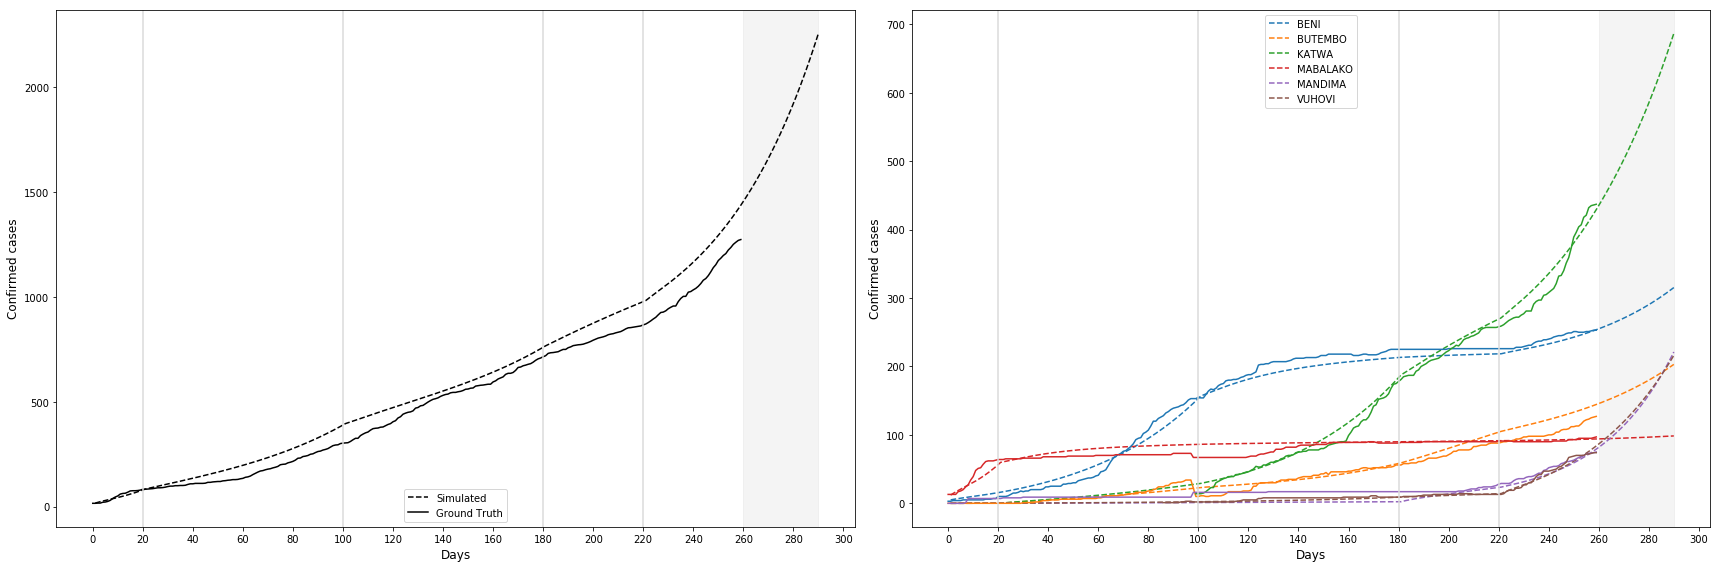

In [47]:
f,axarr = plt.subplots(1,2,figsize=(24,8))

forecast = True
scenario = 'A'
if forecast:
    
    if scenario=='A': 
        temp = pd.read_csv('../data/patchsim/calib_cps/param_stage4.txt',delim_whitespace=True)
        temp.to_csv('../data/patchsim/calib_cps/param_stage5.txt',sep=' ',index=None)
    
    if scenario=='B': 
        temp = pd.read_csv('../data/patchsim/calib_cps/param_stage3.txt',delim_whitespace=True)
        temp.to_csv('../data/patchsim/calib_cps/param_stage5.txt',sep=' ',index=None)

    if scenario=='C':
        temp = pd.read_csv('../data/patchsim/calib_cps/param_stage2.txt',delim_whitespace=True)
        temp.to_csv('../data/patchsim/calib_cps/param_stage5.txt',sep=' ',index=None)
        
out_df = run_patchsim(x_opt,forecast)

if forecast:
    out_dict[scenario] = out_df
    
out_df.sum().cumsum().plot(label='Simulated',ax=axarr[0],color='k',style='--')
axarr[0].plot(gt[gt.health_zone=='all'].total_c.values,label='Ground Truth',color='k')
axarr[0].legend()

out_df.loc[[k.upper() for k in key_hzs]].T.cumsum().plot(ax=axarr[1], style='--')
axarr[1].legend().set_title('')
axarr[1].set_prop_cycle(None)
for h in key_hzs:
    gt[gt.health_zone==h.capitalize()].reset_index().plot(y='total_c',ax=axarr[1],legend=None)
    
cp_timings = [20,100,180,220,246]    
for t in cp_timings[:-1]:
    axarr[0].axvline(t,color='#dbdbdb')
    axarr[1].axvline(t,color='#dbdbdb')
    
loc = plticker.MultipleLocator(base=20) 
axarr[0].xaxis.set_major_locator(loc)
axarr[1].xaxis.set_major_locator(loc)

axarr[0].set_xlabel('Days',fontsize=12)
axarr[1].set_xlabel('Days',fontsize=12)

axarr[0].set_ylabel('Confirmed cases',fontsize=12)
axarr[1].set_ylabel('Confirmed cases',fontsize=12)

if forecast:
    
    axarr[0].axvspan(T,T+30,color='#dbdbdb',alpha=0.3)
    axarr[1].axvspan(T,T+30,color='#dbdbdb',alpha=0.3)
    
    #plt.suptitle('Forecast Scenario {}'.format(scenario),fontsize=16)
    plt.tight_layout()
    plt.savefig('../plots/forecast_scenario_{}.png'.format(scenario),dpi=100)
else:
    #plt.suptitle('Model calibration',fontsize=16)
    plt.tight_layout()
    plt.savefig('../plots/model_calibration.png',dpi=100)
    

if forecast:
    out_df.index = out_df.index.str.replace('_',' ')
    out_wk = out_df.groupby((out_df.columns - 1)// 7, axis=1).sum()
    wk_range = out_wk.columns[:-1]
    out_wk = out_wk[wk_range]

    out_wk['Last5'] = out_wk[wk_range[-5:]].sum(axis=1)
    temp_df = out_wk.sort_values('Last5',ascending=False)[['Last5']]
    temp_df['risk_index'] = temp_df.Last5/temp_df.Last5.sum()
    temp_df[['risk_index']].head(10).to_html('../plots/risk_table_{}.html'.format(scenario))

In [48]:
curve_a = out_dict['A'].sum().cumsum().values
curve_b = out_dict['B'].sum().cumsum().values
curve_c = out_dict['C'].sum().cumsum().values
curve_gt = gt[gt.health_zone=='all']['total_c'].values

tot_a = curve_a[-1]
tot_b = curve_b[-1]
tot_c = curve_c[-1]
tot_gt = curve_gt[-1]

print('Total confirmed cases in ground truth: {}'.format(int(tot_gt)))
print('Total cases in each scenario: A - {}, B - {}, C - {}'.format(int(tot_a),int(tot_b),int(tot_c)))

print('% increase in Scenario A in comparison to ground truth: {}%'.format(round((tot_a-tot_gt)*100/tot_gt,2)))
print('% increase in Scenario B in comparison to ground truth: {}%'.format(round((tot_b-tot_gt)*100/tot_gt,2)))
print('% increase in Scenario C in comparison to ground truth: {}%'.format(round((tot_c-tot_gt)*100/tot_gt,2)))

print('% increase in Scenario A in comparison to scenario B: {}%'.format(round((tot_a-tot_b)*100/tot_b,2)))
print('% increase in Scenario A in comparison to scenario C: {}%'.format(round((tot_a-tot_c)*100/tot_b,2)))


Total confirmed cases in ground truth: 1274
Total cases in each scenario: A - 2257, B - 1774, C - 1955
% increase in Scenario A in comparison to ground truth: 77.18%
% increase in Scenario B in comparison to ground truth: 39.25%
% increase in Scenario C in comparison to ground truth: 53.48%
% increase in Scenario A in comparison to scenario B: 27.23%
% increase in Scenario A in comparison to scenario C: 17.02%


In [49]:
for k in out_dict.keys():
    out_dict[k].to_csv('../outputs/forecast_2019apr25_sc{}.csv'.format(k))